In [6]:
%matplotlib inline
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt, qiime2 as q2
from biom import load_table, Table
from biom.util import biom_open
from skbio import OrdinationResults
from emperor import Emperor, nbinstall; nbinstall()
plt.rcParams['svg.fonttype'] = 'none'

def load_mf(fn, index='#SampleID'):
    _df = pd.read_csv(fn, sep='\t', dtype='str', na_values=[], keep_default_na=False)
    _df.set_index(index, inplace=True)
    return _df

In [7]:
mf = load_mf('data/11546_20190118-122918.txt', 'sample_name')

In [8]:
table = q2.Artifact.load('data/feature-table.qza')
ms = table.view(Table)

Let's look at the distribution of counts per sample. 40K samples looks like a good value, note that samples with small counts are blanks.

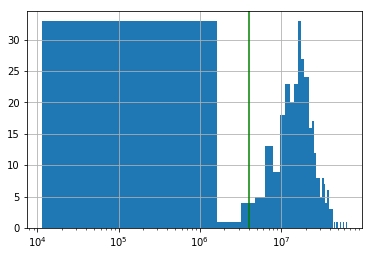

In [9]:
pd.Series(ms.filter(mf.index.intersection(ms.ids()), inplace=False).sum('sample')).hist(bins=40)
plt.gca().set_xscale('log')
plt.axvline(x=4000000, color='g')

Filter to keep only blanks and samples with more than 40K counts.

In [11]:
!qiime feature-table filter-samples \
--i-table data/feature-table.qza \
--m-metadata-file data/11546_20190118-122918.txt \
--p-where "empo_1 == 'Host-associated'" \
--p-min-frequency 40000 \
--o-filtered-table data/feature-table.noblanks.40k.qza 

Saved FeatureTable[Frequency] to: data/feature-table.noblanks.40k.qza


In [3]:
!qiime feature-table rarefy \
--i-table data/feature-table.noblanks.40k.qza \
--p-sampling-depth 40000 \
--p-with-replacement \
--o-rarefied-table data/feature-table.noblanks.even40k.qza

Saved FeatureTable[Frequency] to: data/feature-table.noblanks.even40k.qza


In [4]:
!qiime diversity beta --p-metric braycurtis \
--o-distance-matrix braycurtis.qza \
--i-table data/feature-table.noblanks.even40k.qza

Saved DistanceMatrix to: braycurtis.qza


In [5]:
!qiime diversity pcoa --i-distance-matrix braycurtis.qza \
--o-pcoa braycurtis.pcoa.qza

Saved PCoAResults to: braycurtis.pcoa.qza


In [10]:
bc_pc = q2.Artifact.load('braycurtis.pcoa.qza').view(OrdinationResults)

In [11]:
mf.surgery_type.value_counts()

none                 244
not applicable       125
colectomy             52
ileocolonic           51
partial_colectomy      5
missing                2
Name: surgery_type, dtype: int64

In [12]:
mf.surgery_type.replace({
    'none': 'n',
    'partial_colectomy': 'colectomy'
}, inplace=True)

In [14]:
bc_pc.proportion_explained[:3]

0    0.151598
1    0.118849
2    0.081316
dtype: float64

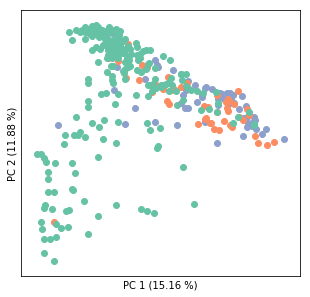

In [15]:
mf['PC 1 (15.16 %)'] = bc_pc.samples[0]
mf['PC 2 (11.88 %)'] = bc_pc.samples[1]

colors = {
    'ileocolonic': '#fc8d62',
    'colectomy': '#8da0cb',
    'none': '#66c2a5',
    'n': '#66c2a5',
    'y': '#e78ac3',
}

fig, ax = plt.subplots()
fig.set_size_inches(5,5)
for cat, _data in mf.loc[mf.index.intersection(bc_pc.samples.index)].groupby('surgery_type'):
    ax.scatter(x='PC 1 (15.16 %)', y='PC 2 (11.88 %)', data=_data, c=colors[cat], label=cat)
    ax.set_xlabel('PC 1 (15.16 %)')
    ax.set_ylabel('PC 2 (11.88 %)')

ax.set_aspect('equal')
plt.xticks([],[])
plt.yticks([],[])

ax.legend().set_visible(False)

fig.savefig('bray-curtis.pdf', transparent=True)